<a href="https://colab.research.google.com/github/ammarameenn/Brain-Tumour-Image-Segmentation/blob/main/Multi_Model_Auto_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***EDA of Brain Tumours Dataset***

In [ ]:
from google.colab import drive
import shutil

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install itk
!pip install itkwidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import os
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import imageio
from IPython.display import Image

from tensorflow.keras import backend as K 
from keras.utils import to_categorical
from tifffile import imsave

import h5py
import tensorflow as tf
#from keras.engine import Input, Model
from keras.layers import Input ##change from keras.engine to keras.layers
from keras.models import Model ##change from keras.engine to keras.models
from keras.layers import (
    Activation,
    Conv3D,
    #Deconvolution3D
    Conv3DTranspose,  ##change from deconvolution3d to transpose convolutions 
    MaxPooling3D,
    UpSampling3D,
)
#from keras.layers.merge import concatenate
from keras.layers import concatenate ##change from keras.layers.merge to keras.layers only
from keras.optimizers import Adam
from tensorflow.compat.v1.logging import INFO, set_verbosity

set_verbosity(INFO)

K.set_image_data_format("channels_first")

In [ ]:
DATA_DIR = "/content/drive/My Drive/BrainTumour/Task01_BrainTumour"

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

In [ ]:
def get_labeled_image(image, label, is_categorical=False):
    if not is_categorical:
        label = to_categorical(label, num_classes=4).astype(np.uint8)

    image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)

    labeled_image = np.zeros_like(label[:, :, :, 1:])

    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
    return labeled_image

In [ ]:
def plot_image_grid(image):
    data_all = []

    data_all.append(image)

    fig, ax = plt.subplots(3, 6, figsize=[16, 9])

    # coronal plane
    coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
    coronal = np.rot90(coronal, 1)

    # transversal plane
    transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
    transversal = np.rot90(transversal, 2)

    # sagittal plane
    sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
    sagittal = np.rot90(sagittal, 1)

    for i in range(6):
        n = np.random.randint(coronal.shape[2])
        ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        if i == 0:
            ax[0][i].set_ylabel('Coronal', fontsize=15)

    for i in range(6):
        n = np.random.randint(transversal.shape[2])
        ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        if i == 0:
            ax[1][i].set_ylabel('Transversal', fontsize=15)

    for i in range(6):
        n = np.random.randint(sagittal.shape[2])
        ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        if i == 0:
            ax[2][i].set_ylabel('Sagittal', fontsize=15)

    fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
def visualize_data_gif(data_):
    images = []
    for i in range(data_.shape[0]):
        x = data_[min(i, data_.shape[0] - 1), :, :]
        y = data_[:, min(i, data_.shape[1] - 1), :]
        z = data_[:, :, min(i, data_.shape[2] - 1)]
        img = np.concatenate((x, y, z), axis=1)
        images.append(img)
    imageio.mimsave("/tmp/gif.gif", images, duration=0.01)
    return Image(filename="/tmp/gif.gif", format='png')

In [ ]:
def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
image, label = load_case("/content/drive/My Drive/BrainTumour/Task01_BrainTumour/imagesTr/BRATS_160.nii.gz", "/content/drive/My Drive/BrainTumour/Task01_BrainTumour/labelsTr/BRATS_160.nii.gz")

In [ ]:
label.shape

(240, 240, 155)

In [ ]:
image = get_labeled_image(image, label)

In [ ]:
image.shape

(240, 240, 155, 3)

### **Images**

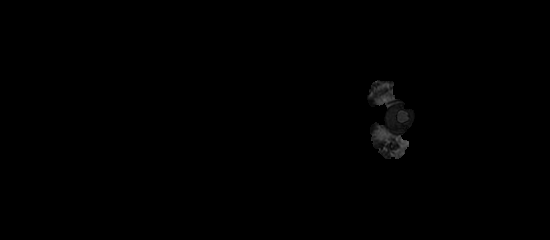

In [ ]:
visualize_data_gif(image)

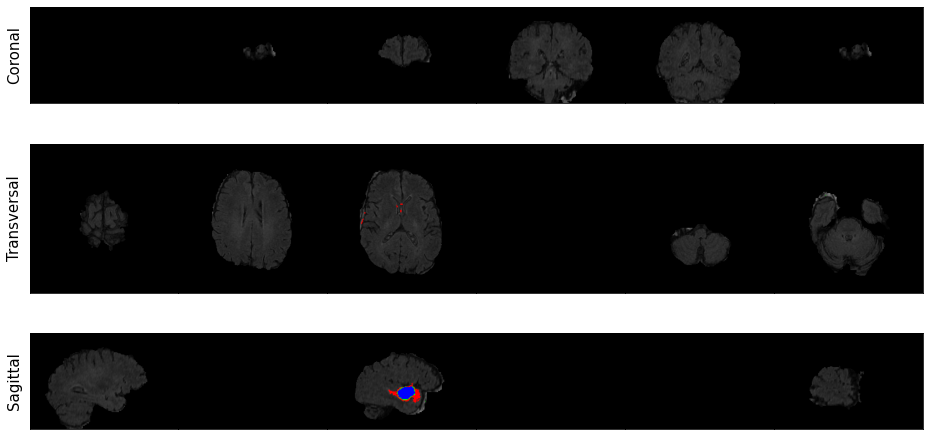

In [ ]:
plot_image_grid(image)

In [ ]:
label.shape

(240, 240, 155)

In [ ]:
height, width, depth, channels = image.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}, channels:{channels}")

The image object has the following dimensions: height: 240, width:240, depth:155, channels:3


Plotting Layer 40 Channel 2 of Image


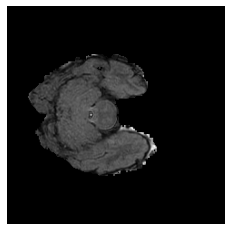

In [ ]:
# Select random layer number
maxval = depth
i = np.random.randint(0, maxval)
# Define a channel to look at
channel = 2
print(f"Plotting Layer {i} Channel {channel} of Image")
plt.imshow(image[:, :, i, channel], cmap='gray')
plt.axis('off');

In [ ]:
image.shape

(240, 240, 155, 3)

In [ ]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    plt.imshow(image[:, :, layer, channel], cmap='gray');
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, image.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

## Labels

In [ ]:
# Extract and print out the shape of the labels data
Lheight, Lwidth, Ldepth = label.shape
val, counts = np.unique(label, return_counts=True)
print(f"Dimensions of labels data array height: {Lheight}, width: {Lwidth}, depth: {Ldepth}")
print(f'With the unique values: {val}')
print(f'With count of each: {counts}')
print("""Corresponding to the following label categories: 
0: for normal 
1: for edema
2: for non-enhancing tumor 
3: for enhancing tumor""")

Dimensions of labels data array height: 240, width: 240, depth: 155
With the unique values: [0. 1. 2. 3.]
With count of each: [8907869    8183    3384    8564]
Corresponding to the following label categories: 
0: for normal 
1: for edema
2: for non-enhancing tumor 
3: for enhancing tumor


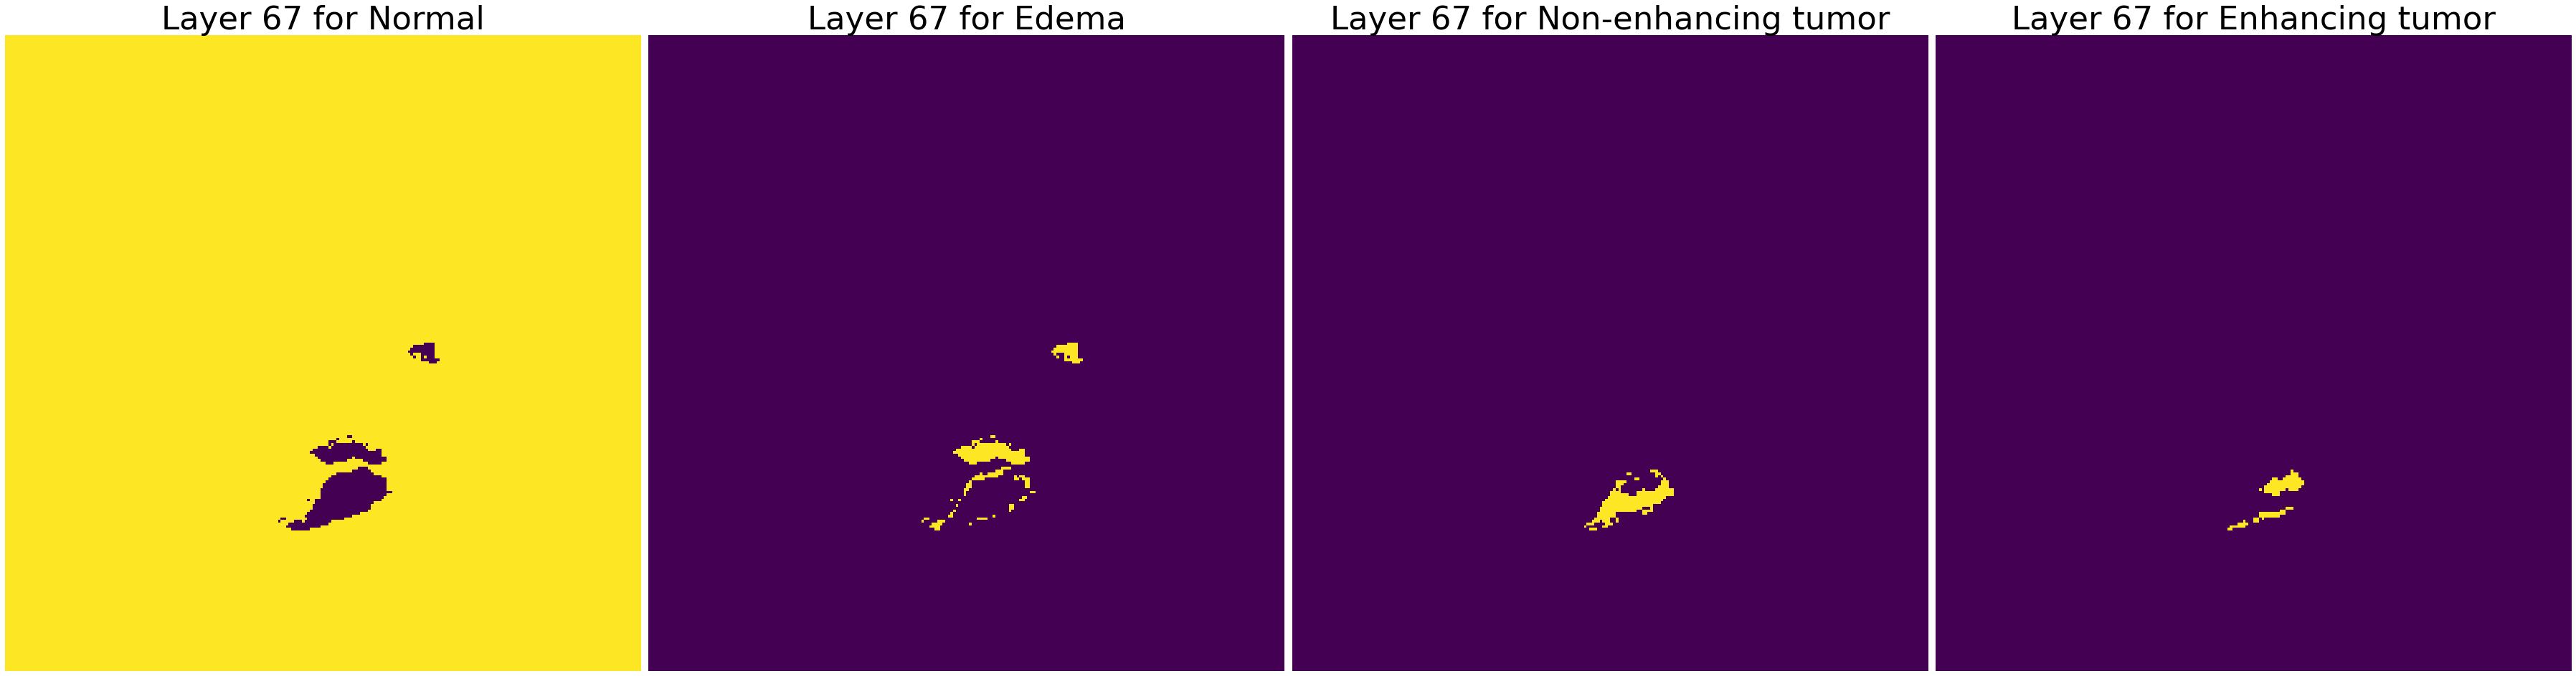

In [ ]:
# Define a single layer for plotting
Lmaxval= Ldepth
layer = np.random.randint(0, Lmaxval)
# Define a dictionary of class labels
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3. 
}
# Set up for plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
for i in range(4):
    img_label_str = list(classes_dict.keys())[i]
    img = label[:,:,layer]
    mask = np.where(img == classes_dict[img_label_str], 255, 0)
    ax[i].imshow(mask)
    ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
    ax[i].axis('off')
plt.tight_layout()

In [ ]:
# Create button values
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info', 
    
)
# Create layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)

    
# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(label[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

# **Data Organization**

In [ ]:
def Normalize(image):
    
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - np.mean(image_slice)
            
            # divide by the standard deviation (only if it is different from zero)
            centered_scaled = centered / np.std(centered)

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] = centered_scaled

    return standardized_image

In [ ]:
def Patch(image, label, Normalize, image_config, label_config, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95,):

  # Initialize features and labels with `None`
    X = None
    y = None
    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        start_x = np.random.randint(0 , orig_x - output_x + 1)
        start_y = np.random.randint(0 , orig_y - output_y + 1)
        start_z = np.random.randint(0 , orig_z - output_z + 1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes = num_classes)

        # compute the background ratio
        #bgrd_ratio = np.sum(y[:,:,:,0]) / (output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        val, counts = np.unique(y, return_counts=True)
    
        if (1 - (counts[1]/counts.sum())) > 0.05:
        #if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X,3,0)
            X = Normalize(X)
            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y,3,0)

            ### END CODE HERE ###
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]

        else:
          print('function is not working properly')

    np.save(os.path.join('/content/drive/My Drive/'+'TrainingImages/')+str(image_config)+'.npy', X)
    np.save(os.path.join('/content/drive/My Drive/'+'TrainingLabels/')+str(label_config)+'.npy', y)

In [ ]:
def PreProcessed_data(DATA_DIR,Patch,Normalize):
    with open(DATA_DIR + "/dataset.json") as json_file:
      config = json.load(json_file)

    training_image = [ item['image'] for item in config['training'] ]
    training_image.sort()
    training_image = training_image[357:]
    training_label = [ itemm['label'] for itemm in config['training'] ]
    training_label.sort()
    training_label = training_label[357:]

    for i in range(len(training_image)):
      image, label = load_case("/content/drive/My Drive/BrainTumour/Task01_BrainTumour/"+str(training_image[i][2:]), "/content/drive/My Drive/BrainTumour/Task01_BrainTumour/"+str(training_label[i][2:]))
      image = get_labeled_image(image, label)
      Patch(image,label,Normalize,image_config =training_image[i][11:], label_config = training_label[i][11:] )

In [ ]:
#PreProcessed_data(DATA_DIR,Patch,Normalize)

In [ ]:
my_img=np.load('/content/drive/My Drive/TrainingImages/BRATS_169.nii.gz.npy')

In [ ]:
my_img.shape

(3, 160, 160, 16)

In [ ]:
my_label = np.load('/content/drive/My Drive/TrainingLabels/BRATS_169.nii.gz.npy')

In [ ]:
my_label.shape

(3, 160, 160, 16)

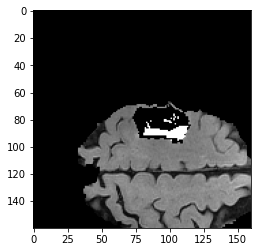

In [ ]:
plt.imshow(my_img[1,:, :, 15], cmap='Greys_r')

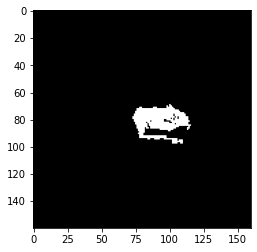

In [ ]:
plt.imshow(my_label[0,:,:,15], cmap='Greys_r')

In [ ]:
with open(DATA_DIR + "/dataset.json") as json_file:
  config = json.load(json_file)

In [ ]:
config['training'][0]['image'][2:]

'imagesTr/BRATS_457.nii.gz'

# **Training**

### **Data Generator 1**

In [ ]:
# def load_img(img_dir, img_list):
#     images=[]
#     for i in range(len(img_list)):    
#         if (img_list[i].split('.')[3] == 'npy'):
            
#             image = np.load(img_dir+img_list[i])
                      
#             images.append(image)
#     images = np.array(images)
    
#     return(images)

# def MyGenerator(img_dir, img_list, mask_dir, mask_list, batch_size):

#     L = len(img_list)

#     #keras needs the generator infinite, so we using while true  
#     while True:
#       try:
#         batch_start = 0
#         batch_end = batch_size

#         while batch_start < L:
#             limit = min(batch_end, L)
                       
#             X = load_img(img_dir, img_list[batch_start:limit])
#             X = cv2.normalize(X, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#             Y = load_img(mask_dir, mask_list[batch_start:limit])
#             if np.isnan(X).any() or np.isnan(Y).any():
#               img_list.remove(img_list[batch_start:limit])
#               mask_list.remove(mask_list[batch_start:limit])
#               continue

#             yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

#             batch_start += batch_size   
#             batch_end   += batch_size

#       except StopIteration as e:

#         print(e)
#         break

### **Data Generator 2**

In [ ]:
class VolumeDataGenerator(keras.utils.Sequence):
    def __init__(self,
                 sample_list,
                 base_dir,
                 batch_size=3,
                 shuffle=True,
                 dim=(160, 160, 16),
                 num_channels=3,
                 num_classes=3,
                 verbose=1):  #verbose is just a counter flag
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.dim = dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.sample_list = sample_list
        self.on_epoch_end() #If you want to modify your dataset between epochs, you may implement this method
        self.n = 0
        self.max = self.__len__()  

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_list) / self.batch_size))

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'

        # Initialization
        X = np.zeros((self.batch_size, self.num_channels, *self.dim),
                     dtype=np.float64)
        y = np.zeros((self.batch_size, self.num_classes, *self.dim),
                     dtype=np.float64)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.verbose == 1:
                print("Training on: %s" % self.base_dir + ID)

            X[i] = np.load(base_dir+ 'TrainingImages/' + ID )
            X[i] = cv2.normalize(X[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            y[i] = np.load(base_dir+ 'TrainingLabels/' + ID )
            if np.isnan(X[i]).any() or np.isnan(y[i]).any():
              print('The nan value is found in the following ID:',ID)

        return X, y

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        sample_list_temp = [self.sample_list[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(sample_list_temp)

        return X, y

    def __next__(self):
        if self.n >= self.max:
           self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result


To check if the pre processed images containing NaN values

In [ ]:
base_dir = '/content/drive/MyDrive/'
pro_image_dir = "/content/drive/My Drive/TrainingImages/"
pro_label_dir = "/content/drive/My Drive/TrainingLabels/"
pro_image_list = os.listdir(pro_image_dir)
pro_label_list = os.listdir(pro_label_dir)
nan_list=[]
for i in range(len(pro_image_list)):
  temp_img = np.load('/content/drive/My Drive/TrainingImages/' + pro_image_list[i])
  if np.isnan(temp_img).any() == True:
    nan_list.append(pro_image_list[i])

In [ ]:
final_image_list = [x for x in pro_image_list if x not in nan_list]
final_label_list = [y for y in pro_label_list if y not in nan_list]
Train_images = final_image_list[:336]
Train_labels= final_label_list[:336]
validation_images = final_image_list[336:]
validation_labels = final_label_list[336:]
batch_size = 3
# train_generator = MyGenerator(pro_image_dir, Train_images, pro_label_dir, Train_labels, batch_size)
# validation_generator = MyGenerator(pro_image_dir, validation_images, pro_label_dir, validation_labels, batch_size)
train_generator = VolumeDataGenerator(Train_images, base_dir + 'TrainingImages/', batch_size=3, dim=(160, 160, 16), verbose=0)
valid_generator = VolumeDataGenerator(validation_images, base_dir + 'TrainingImages/', batch_size=3, dim=(160, 160, 16), verbose=0)

In [ ]:
# x_batch, y_batch = next(train_generator)

In [ ]:
# np.isnan(y_batch[0]).any()

In [ ]:
# a = np.empty((3,3,))
# a[:] = np.nan
# a

In [ ]:
# if np.isnan(a[0]).any():
#   print('Yes there is nan value')
# else:
#   print('No there is no nan value')

### **Model Architecture ( 3D Unet) and loss function**

In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """
    
    dice_numerator = 2 * K.sum(y_true * y_pred , axis = axis) + epsilon
    dice_denominator = K.sum(y_true, axis = axis ) + K.sum(y_pred, axis = axis) + epsilon
    dice_coefficient = K.mean(dice_numerator/dice_denominator)

    return dice_coefficient

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2 * K.sum(y_true * y_pred , axis= axis) + epsilon
    dice_denominator = K.sum(y_true ** 2, axis= axis) + K.sum(y_pred ** 2 , axis = axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)

    return dice_loss

In [ ]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)


def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2),
                       strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

In [ ]:
def unet_model_3d(loss_function, input_shape=(3, 160, 160, 16),
                  pool_size=(2, 2, 2), n_labels=3,
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=4, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"):
    """
    Builds the 3D UNet Keras model.f
    :param metrics: List metrics to be calculated during model training (default is dice coefficient).
    :param include_label_wise_dice_coefficients: If True and n_labels is greater than 1, model will report the dice
    coefficient for each label as metric.
    :param n_base_filters: The number of filters that the first layer in the convolution network will have. Following
    layers will contain a multiple of this number. Lowering this number will likely reduce the amount of memory required
    to train the model.
    :param depth: indicates the depth of the U-shape for the model. The greater the depth, the more max pooling
    layers will be added to the model. Lowering the depth may reduce the amount of memory required for training.
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). The x, y, and z sizes must be
    divisible by the pool size to the power of the depth of the UNet, that is pool_size^depth.
    :param pool_size: Pool size for the max pooling operations.
    :param n_labels: Number of binary labels that the model is learning.
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of up-sampling. This
    increases the amount memory required during training.
    :return: Untrained 3D UNet Model
    """
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=
                                            current_layer.shape[1])(
            current_layer)
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1].shape[1],
            input_layer=concat, batch_normalization=batch_normalization)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1].shape[1],
            input_layer=current_layer,
            batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model


## **Training**

In [ ]:
# model = unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

In [ ]:
# steps_per_epoch = 20
# n_epochs=10
# val_steps_per_epoch = 20

possible reasons for loss function to go nan/infinity. This is when your model is said to diverge:
1. if the learning rate is too large
2. if the image is not normalized before training. 
3. if any pixel value is itself nan by checking '**np.any(np.isnan(x))**' where x is the image
4. Other numerical stability issues can exist such as division by zero where adding the epsilon can help.

In [ ]:
# LessGo=model.fit(train_generator,
#           steps_per_epoch=steps_per_epoch,
#           epochs=100,
#           verbose=1,
#           validation_data=valid_generator,
#           validation_steps=val_steps_per_epoch,
#           )

In [ ]:
# model.save_weights(base_dir + 'my_model_pretrained.hdf5')

Stop the training for now after 100 epochs. Gonna work with the until trained model for now.

**Loading the trained model**

In [ ]:
model = unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

The `lr` argument is deprecated, use `learning_rate` instead.


In [ ]:
model.load_weights(base_dir + "my_model_pretrained.hdf5")

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 160, 160  0           []                               
                                , 16)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 32, 160, 160  2624        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 activation (Activation)        (None, 32, 160, 160  0           ['conv3d[0][0]']                 
                                , 16)                                                         

Note that due to the randomness in choosing sub-volumes, the values for soft dice loss and dice coefficient will be different each time that you run it.

In [ ]:
val_loss, val_dice = model.evaluate_generator(valid_generator)

print(f"validation soft dice loss: {val_loss:.4f}")
print(f"validation dice coefficient: {val_dice:.4f}")

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


validation soft dice loss: 0.0553
validation dice coefficient: 0.8933


### **Patch-level predictions**

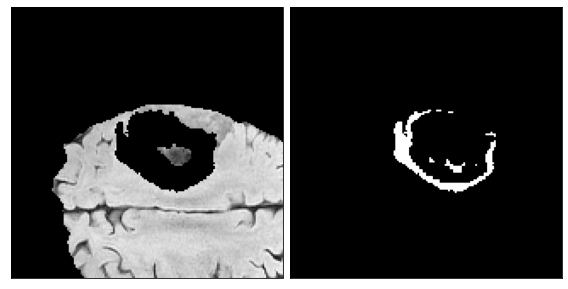

In [ ]:
visualize_patch(my_img[2, :, :, :], my_label[0])

In [ ]:
my_img.shape

(3, 160, 160, 16)

In [ ]:
my_img_with_batch_dimension = np.expand_dims(my_img, axis=0)
patch_pred = model.predict(my_img_with_batch_dimension)

1/1 [==============================] - 3s 3s/step


In [ ]:
# set threshold.
threshold = 0.5

# use threshold to get hard predictions
patch_pred[patch_pred > threshold] = 1.0
patch_pred[patch_pred <= threshold] = 0.0

Patch and ground truth


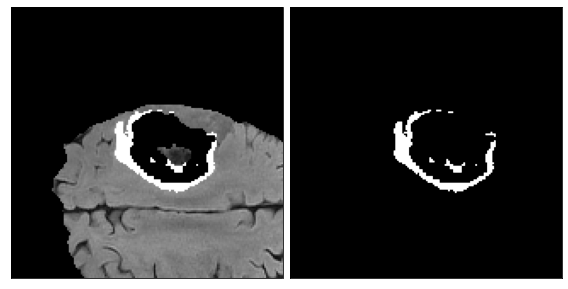

Patch and prediction


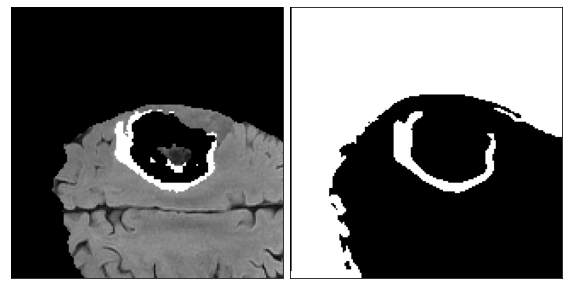

In [ ]:
print("Patch and ground truth")
visualize_patch(my_img[0, :, :, :], my_label[0,:,:,:])
plt.show()
print("Patch and prediction")
visualize_patch(my_img[0, :, :, :], patch_pred[0, 0, :, :, :])
plt.show()

In [ ]:
def compute_class_sens_spec(pred, label, class_num):
    """
    Compute sensitivity and specificity for a particular example
    for a given class.

    Args:
        pred (np.array): binary arrary of predictions, shape is
                         (num classes, height, width, depth).
        label (np.array): binary array of labels, shape is
                          (num classes, height, width, depth).
        class_num (int): number between 0 - (num_classes -1) which says
                         which prediction class to compute statistics
                         for.

    Returns:
        sensitivity (float): precision for given class_num.
        specificity (float): recall for given class_num
    """

    # extract sub-array for specified class
    class_pred = pred[class_num]
    class_label = label[class_num]

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute:
    
    # true positives
    tp = np.sum( (class_pred == 1) * (class_label == 1))

    # true negatives
    tn = np.sum( (class_pred == 0) * (class_label == 0))
    
    #false positives
    fp = np.sum( (class_pred == 1) * (class_label == 0))
    
    # false negatives
    fn = np.sum( (class_pred == 0) * (class_label == 1))

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    ### END CODE HERE ###

    return sensitivity, specificity

In [ ]:
sensitivity, specificity = compute_class_sens_spec(patch_pred[0], my_label, 2)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.0000
Specificity: 0.9949


In [ ]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [ ]:
df = get_sens_spec_df(patch_pred[0], my_label)

print(df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.9319              0.9638             0.0
Specificity  0.4575              0.4362          0.9949


### **Entire scans level prediction**

In [ ]:
def predict_and_viz(image, label, model, threshold, loc=(100, 100, 50)):
    image_labeled = get_labeled_image(image.copy(), label.copy())

    model_label = np.zeros([3, 320, 320, 160])

    for x in range(0, image.shape[0], 160):
        for y in range(0, image.shape[1], 160):
            for z in range(0, image.shape[2], 16):
                patch = np.zeros([3, 160, 160, 16])
                p = np.moveaxis(image[x: x + 160, y: y + 160, z:z + 16], 3, 0)
                patch[:, 0:p.shape[1], 0:p.shape[2], 0:p.shape[3]] = p
                pred = model.predict(np.expand_dims(patch, 0))
                model_label[:, x:x + p.shape[1],
                y:y + p.shape[2],
                z: z + p.shape[3]] += pred[0][:, :p.shape[1], :p.shape[2],
                                      :p.shape[3]]

    model_label = np.moveaxis(model_label[:, 0:240, 0:240, 0:155], 0, 3)
    model_label_reformatted = np.zeros((240, 240, 155, 4))

    model_label_reformatted = to_categorical(label, num_classes=4).astype(
        np.uint8)

    model_label_reformatted[:, :, :, 1:4] = model_label

    model_labeled_image = get_labeled_image(image, model_label_reformatted,
                                            is_categorical=True)

    fig, ax = plt.subplots(2, 3, figsize=[10, 7])

    # plane values
    x, y, z = loc

    ax[0][0].imshow(np.rot90(image_labeled[x, :, :, :]))
    ax[0][0].set_ylabel('Ground Truth', fontsize=15)
    ax[0][0].set_xlabel('Sagital', fontsize=15)

    ax[0][1].imshow(np.rot90(image_labeled[:, y, :, :]))
    ax[0][1].set_xlabel('Coronal', fontsize=15)

    ax[0][2].imshow(np.squeeze(image_labeled[:, :, z, :]))
    ax[0][2].set_xlabel('Transversal', fontsize=15)

    ax[1][0].imshow(np.rot90(model_labeled_image[x, :, :, :]))
    ax[1][0].set_ylabel('Prediction', fontsize=15)

    ax[1][1].imshow(np.rot90(model_labeled_image[:, y, :, :]))
    ax[1][2].imshow(model_labeled_image[:, :, z, :])

    fig.subplots_adjust(wspace=0, hspace=.12)

    for i in range(2):
        for j in range(3):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])

    return model_label_reformatted

In [ ]:
iimage, llabel = load_case("/content/drive/My Drive/BrainTumour/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz", "/content/drive/My Drive/BrainTumour/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz")      

In [ ]:
iimage = get_labeled_image(iimage, llabel)

1/1 [==============================] - 0s 23ms/step


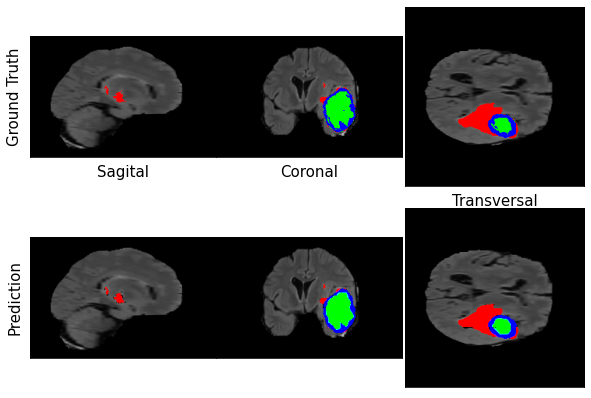

In [ ]:
pred = predict_and_viz(iimage, llabel, model, .5, loc=(130, 130, 77))

1/1 [==============================] - 0s 21ms/step


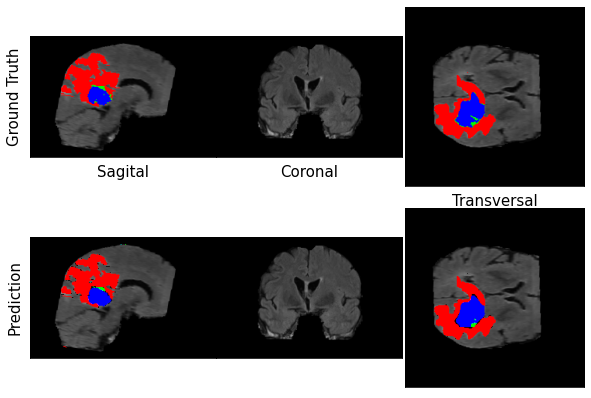

In [ ]:
iiimage, lllabel = load_case("/content/drive/My Drive/BrainTumour/Task01_BrainTumour/imagesTr/BRATS_003.nii.gz", "/content/drive/My Drive/BrainTumour/Task01_BrainTumour/labelsTr/BRATS_003.nii.gz")
iiimage = get_labeled_image(iiimage, lllabel)
pred = predict_and_viz(iiimage, lllabel, model, .5, loc=(130, 130, 77)) 

In [ ]:
whole_scan_label = keras.utils.to_categorical(lllabel, num_classes = 4)
whole_scan_pred = pred

# move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]

In [ ]:
whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)

             Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.972              0.4089          0.9448
Specificity  0.999                 1.0          0.9997
